In [40]:
import os
import json
import time
import numpy as np
import pandas as pd
from pandas.io.json import json_normalize
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()

%matplotlib inline

from plotly import tools
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go

from sklearn import model_selection, preprocessing, metrics

import lightgbm as lgb


# pd.options.model.chained_assignment = None
# pd.options.display.max_columns = 999

In [2]:
#  数据探索, 在这一部分, 我们先看看给定的文件, 然后进行数据探索
!ls data/

Data_Dictionary.xlsx          sample_submission.csv
historical_transactions.csv   test.csv
merchants.csv                 train.csv
new_merchant_transactions.csv


In [67]:
# 首先探索一下 训练数据和测试数据
train_df = pd.read_csv('data/train.csv', parse_dates=['first_active_month'])
test_df = pd.read_csv('data/test.csv', parse_dates=['first_active_month'])
print('Number of rows and columns in train set :', train_df.shape)
print('Number of rows and columns in test set :', test_df.shape)


Number of rows and columns in train set : (201917, 6)
Number of rows and columns in test set : (123623, 5)


123623

In [68]:
train_df.head()

,first_active_month,card_id,feature_1,feature_2,feature_3,target
0,2017-06-01,C_ID_92a2005557,5,2,1,-0.820283
1,2017-01-01,C_ID_3d0044924f,4,1,0,0.392913
2,2016-08-01,C_ID_d639edf6cd,2,2,0,0.688056
3,2017-09-01,C_ID_186d6a6901,4,3,0,0.142495
4,2017-11-01,C_ID_cdbd2c0db2,1,3,0,-0.159749


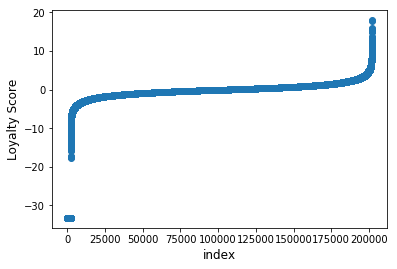

In [9]:
 目标列研究,散点图
target_col = 'target'
plt.figure(figsize = (6,4))
plt.scatter(range(train_df.shape[0]), np.sort(train_df[target_col].values))
plt.xlabel('index', fontsize = 12)
plt.ylabel('Loyalty Score', fontsize = 12)
plt.show()

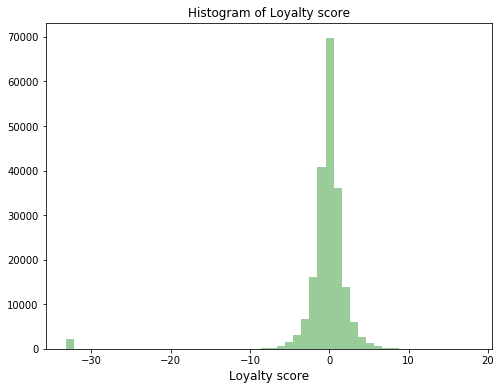

In [13]:
#  忠诚度得分 柱状图分布
plt.figure(figsize = (8,6))
sns.distplot(train_df[target_col].values, bins = 50, kde=False,color='green')
plt.title('Histogram of Loyalty score')
plt.xlabel('Loyalty score', fontsize=12)
plt.show()

In [14]:
#  我们可以看到 有一些 忠诚度得分(小于-30分) 与其他相比相差太多, 查一下小于-30 的人数
(train_df[target_col] < -30).sum()

2207

In [ ]:
# 这里大有2207行(差不多总数据的1%),这些值跟其他的很不同, 因为度量RMSE,这些行
# 可能很重要,因此要注意他们

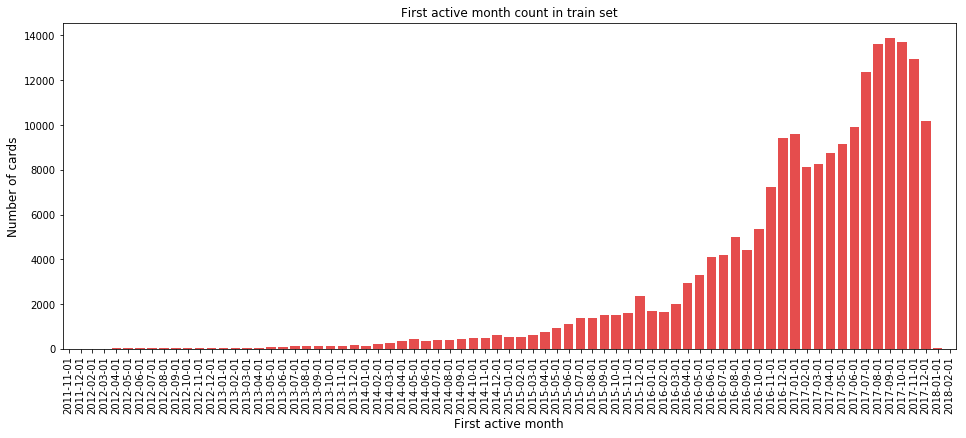

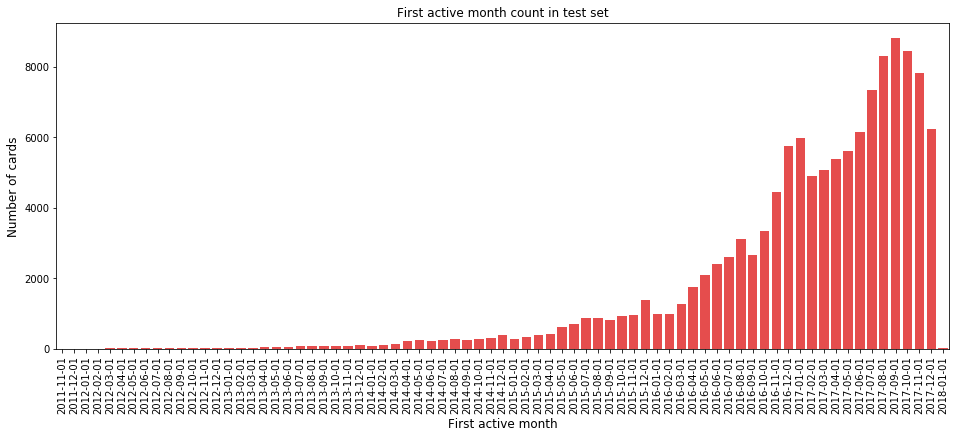

In [31]:
# First Active Month
# 看看在每个月 有多少用户 激活了卡
cnt_srs = train_df['first_active_month'].dt.date.value_counts()
cnt_srs = cnt_srs.sort_index()
plt.figure(figsize =(16,6))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8,color='red')
plt.xticks(rotation='vertical')
plt.xlabel('First active month', fontsize=12)
plt.ylabel('Number of cards', fontsize=12)
plt.title('First active month count in train set')
plt.show()

cnt_srs = test_df['first_active_month'].dt.date.value_counts()
cnt_srs = cnt_srs.sort_index()
plt.figure(figsize = (16,6))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8, color='red')
plt.xticks(rotation='vertical')
plt.xlabel('First active month', fontsize=12)
plt.ylabel('Number of cards', fontsize=12)
plt.title('First active month count in test set')
plt.show()




In [32]:
# 看起来, 训练数据和测试数据 卡片分布的时间是类似的, 因此可以不需要做时间的分割


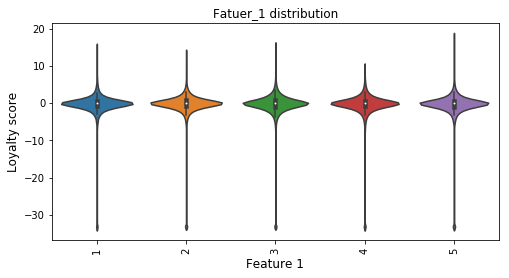

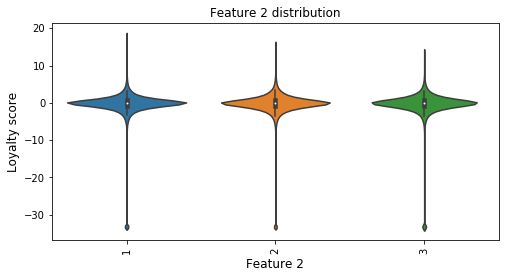

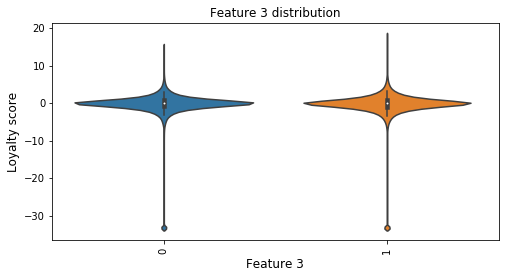

In [38]:
# Feature 1,2,3
#  使用violinplot(小提琴绘图)
plt.figure(figsize=(8,4))
sns.violinplot(x='feature_1',y=target_col,data=train_df)
plt.xticks(rotation='vertical')
plt.xlabel('Feature 1', fontsize=12)
plt.ylabel('Loyalty score', fontsize=12)
plt.title('Fatuer_1 distribution')
plt.show()

plt.figure(figsize=(8,4))
sns.violinplot(x='feature_2', y=target_col,data=train_df)
plt.xticks(rotation='vertical')
plt.xlabel('Feature 2',fontsize=12)
plt.ylabel('Loyalty score', fontsize=12)
plt.title('Feature 2 distribution')
plt.show()

plt.figure(figsize=(8,4))
sns.violinplot(x='feature_3',y=target_col,data=train_df)
plt.xticks(rotation='vertical')
plt.xlabel('Feature 3',fontsize=12)
plt.ylabel('Loyalty score', fontsize=12)
plt.title('Feature 3 distribution')
plt.show()

In [39]:
#  从肉眼来看, 这三个变量中的不同类别的分布有些类似, 或许使用模型能从中看出不同

In [42]:
# Historical Transcations 历史交易
# 现在来看一下这些卡的历史交易
%%time
his_df = pd.read_csv('data/historical_transactions.csv')
his_df.head()

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 8.11 µs


,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_e020e9b302,-8,-0.703331,2017-06-25 15:33:07,1.0,16,37
1,Y,C_ID_4e6213e9bc,88,N,0,A,367,M_ID_86ec983688,-7,-0.733128,2017-07-15 12:10:45,1.0,16,16
2,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_979ed661fc,-6,-0.720386,2017-08-09 22:04:29,1.0,16,37
3,Y,C_ID_4e6213e9bc,88,N,0,A,560,M_ID_e6d5ae8ea6,-5,-0.735352,2017-09-02 10:06:26,1.0,16,34
4,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_e020e9b302,-11,-0.722865,2017-03-10 01:14:19,1.0,16,37


In [43]:
'''
authorized_flag : 授权标识, Y:授权,N:拒绝
card_id : 卡片id
city_id : 城市id
category_1 : 匿名类别
installments: 分期购买数量
category_3 : 匿名类别
merchant_category_id : 商户类别标识(匿名)
subsector_id :  商户类别标识(匿名)
month_lag : 到参考日期的月份延迟
purchase_amount : 归一化的购买数量
purchase_date : 购买日期
category_2 : 匿名类别
state_id : 状态标识(匿名)
'''



'\nauthorized_flag : 授权标识, Y:授权,N:拒绝\ncard_id : 卡片id\ncity_id : 城市id\ncategory_1 : 匿名类别\ninstallments: 分期购买数量\ncategory_3 : 匿名类别\nmerchant_category_id : 商户类别标识(匿名)\nsubsector_id :  商户类别标识(匿名)\nmonth_lag : 到参考日期的月份延迟\npurchase_amount : 归一化的购买数量\npurchase_date : 购买日期\ncategory_2 : 匿名类别\nstate_id : 状态标识(匿名)\n'

In [65]:
# 现在让我们基于 历史交易数据做一些功能,然后将其与训练和测试数据合并
# 卡的历史交易数量
gdf = his_df.groupby('card_id')
gdf = gdf['purchase_amount'].size().reset_index()

gdf.columns = ['card_id', 'num_hist_transactions']
gdf.head()


,card_id,num_hist_transactions
0,C_ID_00007093c1,149
1,C_ID_0001238066,123
2,C_ID_0001506ef0,66
3,C_ID_0001793786,216
4,C_ID_000183fdda,144


In [57]:
print('The card_id count of the train set :', train_df['card_id'].nunique())
print('The card_id count of the test set :', test_df['card_id'].nunique())


The card_id count of the train set : 201917
The card_id count of the test set : 123623


In [69]:
train_df = pd.merge(train_df, gdf,on='card_id', how='left')
test_df = pd.merge(test_df, gdf, on='card_id', how='left')

In [70]:
train_df.head(2)

,first_active_month,card_id,feature_1,feature_2,feature_3,target,num_hist_transactions
0,2017-06-01,C_ID_92a2005557,5,2,1,-0.820283,260
1,2017-01-01,C_ID_3d0044924f,4,1,0,0.392913,350


In [76]:
cnt_srs = train_df.groupby('num_hist_transactions')[target_col].mean()
cnt_srs = cnt_srs.sort_index()
# cnt_srs = cnt_srs[:-50]
cnt_srs = cnt_srs[:-50]

def scatter_plot(cnt_srs, color):
    trace = go.Scatter(
        x=cnt_srs.index[::-1],
        y=cnt_srs.values[::-1],
        showlegend=False,
        marker=dict(color=color,),
    )
    return trace
trace = scatter_plot(cnt_srs, 'green')
layout = dict(
    title = 'Loyalty score by Number of historical transactions',
)
data = [trace]
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename = 'Histtranscnt')

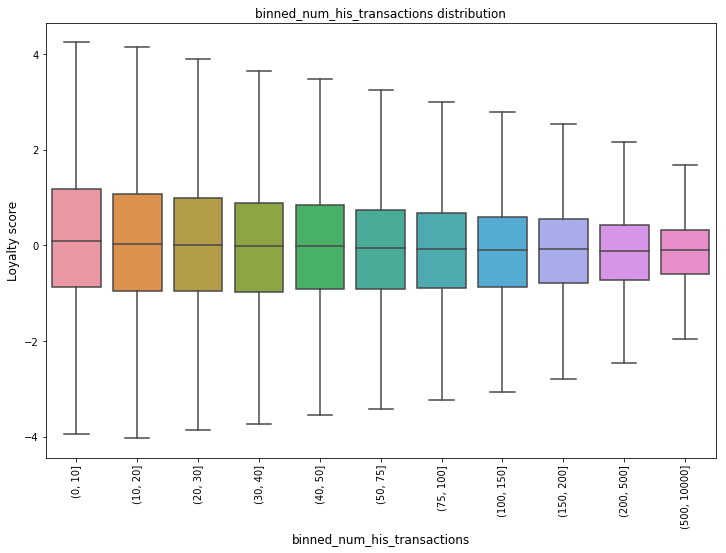

In [79]:
#  再做一些箱型图, 更好的看这些图
bins = [0,10,20,30,40,50,75,100,150,200,500,10000]
train_df['binned_num_his_transactions'] = pd.cut(train_df['num_hist_transactions'], bins)
cnt_srs = train_df.groupby('binned_num_his_transactions')[target_col].mean()

plt.figure(figsize=(12,8))
sns.boxplot(x='binned_num_his_transactions', y=target_col,data=train_df, showfliers=False)
plt.xticks(rotation='vertical')
plt.xlabel('binned_num_his_transactions', fontsize=12)
plt.ylabel('Loyalty score', fontsize=12)
plt.title('binned_num_his_transactions distribution')
plt.show()


In [80]:
# 历史交易价值
# 现在让我们检查一下卡的历史交易价值, 并基于该值检查忠诚度的分布

gdf = his_df.groupby('card_id')
gdf = gdf['purchase_amount'].agg(['sum','mean','std','min','max']).reset_index()
gdf.columns = ['card_id','sum_hist_trans','mean_hist_trans',
              'set_hist_trans','min_hist_trans','max_hist_trans']
train_df = pd.merge(train_df, gdf, on='card_id', how='left')
test_df = pd.merge(test_df, gdf, on='card_id', how='left')


In [81]:
train_df.head(2)

,first_active_month,card_id,feature_1,feature_2,feature_3,target,num_hist_transactions,binned_num_his_transactions,sum_hist_trans,mean_hist_trans,set_hist_trans,min_hist_trans,max_hist_trans
0,2017-06-01,C_ID_92a2005557,5,2,1,-0.820283,260,"(200, 500]",-165.968739,-0.638341,0.212139,-0.739395,2.258395
1,2017-01-01,C_ID_3d0044924f,4,1,0,0.392913,350,"(200, 500]",-210.006336,-0.600018,0.384967,-0.742400,4.630299


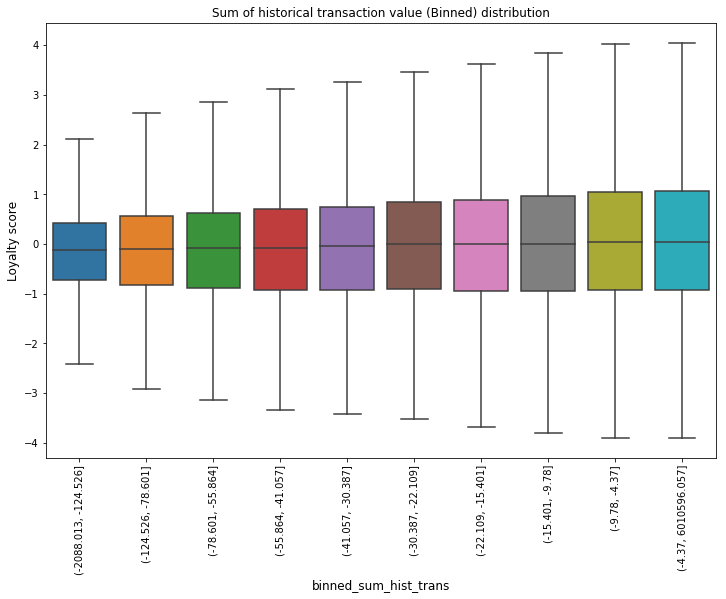

In [85]:
bins = np.percentile(train_df['sum_hist_trans'], range(0,101,10))
train_df['binned_sum_hist_trans'] = pd.cut(train_df['sum_hist_trans'],bins)

plt.figure(figsize=(12,8))
sns.boxplot(x='binned_sum_hist_trans',y=target_col,data=train_df,showfliers=False)
plt.xticks(rotation='vertical')
plt.xlabel('binned_sum_hist_trans',fontsize=12)
plt.ylabel('Loyalty score', fontsize=12)
plt.title('Sum of historical transaction value (Binned) distribution')
plt.show()





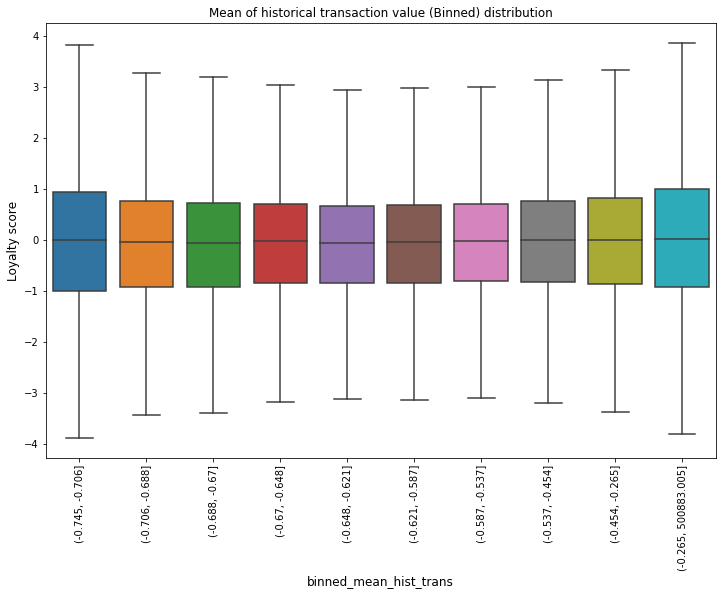

In [86]:
# 正如我们所看到的, 忠诚度得分随着 历史交易价值总和的增加而增加,
# 这正如我们预期的一样, 现在我们可以用同样的方法查看'Mean value of historical transaction'
bins = np.percentile(train_df['mean_hist_trans'], range(0,101,10))
train_df['binned_mean_hist_trans'] = pd.cut(train_df['mean_hist_trans'],bins)

plt.figure(figsize=(12,8))
sns.boxplot(x='binned_mean_hist_trans',y=target_col,data=train_df,showfliers=False)
plt.xticks(rotation='vertical')
plt.xlabel('binned_mean_hist_trans',fontsize=12)
plt.ylabel('Loyalty score', fontsize=12)
plt.title('Mean of historical transaction value (Binned) distribution')
plt.show()


In [87]:
# 新商户交易
# 在之后 让我们看看新商户交易数据 然后做一些分析

In [88]:
new_trans_df = pd.read_csv('data/new_merchant_transactions.csv')
new_trans_df.head()

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,Y,C_ID_415bb3a509,107,N,1,B,307,M_ID_b0c793002c,1,-0.557574,2018-03-11 14:57:36,1.0,9,19
1,Y,C_ID_415bb3a509,140,N,1,B,307,M_ID_88920c89e8,1,-0.569580,2018-03-19 18:53:37,1.0,9,19
2,Y,C_ID_415bb3a509,330,N,1,B,507,M_ID_ad5237ef6b,2,-0.551037,2018-04-26 14:08:44,1.0,9,14
3,Y,C_ID_415bb3a509,-1,Y,1,B,661,M_ID_9e84cda3b1,1,-0.671925,2018-03-07 09:43:21,NaN,-1,8
4,Y,C_ID_ef55cf8d4b,-1,Y,1,B,166,M_ID_3c86fa3831,1,-0.659904,2018-03-22 21:07:53,NaN,-1,29


In [89]:
gdf = new_trans_df.groupby('card_id')
gdf = gdf['purchase_amount'].size().reset_index()
gdf.columns = ['card_id', 'num_merch_transactions']
train_df = pd.merge(train_df, gdf, on='card_id', how='left')
test_df = pd.merge(test_df, gdf, on='card_id', how='left')


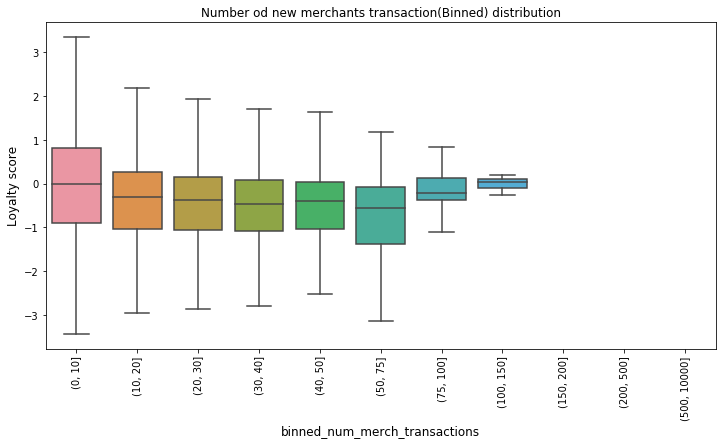

In [91]:
bins = [0,10,20,30,40,50,75,100,150,200,500,10000]
train_df['binned_num_merch_transactions'] = pd.cut(train_df['num_merch_transactions'],bins)
cnts = train_df.groupby('binned_num_merch_transactions')[target_col].mean()

plt.figure(figsize=(12,6))
sns.boxplot(x='binned_num_merch_transactions',y=target_col,data=train_df,showfliers=False)
plt.xticks(rotation='vertical')
plt.xlabel('binned_num_merch_transactions',fontsize=12)
plt.ylabel('Loyalty score',fontsize=12)
plt.title('Number od new merchants transaction(Binned) distribution')
plt.show()


In [93]:
# 用户忠诚度似乎随着交易量的增加而下降, 除了超过75的

In [94]:
gdf = new_trans_df.groupby('card_id')
gdf = gdf['purchase_amount'].agg(['sum','mean','std','min','max']).reset_index()
gdf.columns = ['card_id', 'sum_merch_trans', 'mean_merch_trans',
               'std_merch_trans', 'min_merch_trans', 'max_merch_trans',]

train_df = pd.merge(train_df, gdf, on='card_id', how='left')
test_df = pd.merge(test_df, gdf, on='card_id', how='left')


In [96]:
train_df.head(2)

,first_active_month,card_id,feature_1,feature_2,feature_3,target,num_hist_transactions,binned_num_his_transactions,sum_hist_trans,mean_hist_trans,...,max_hist_trans,binned_sum_hist_trans,binned_mean_hist_trans,num_merch_transactions,binned_num_merch_transactions,sum_merch_trans,mean_merch_trans,std_merch_trans,min_merch_trans,max_merch_trans
0,2017-06-01,C_ID_92a2005557,5,2,1,-0.820283,260,"(200, 500]",-165.968739,-0.638341,...,2.258395,"(-2088.013, -124.526]","(-0.648, -0.621]",23.0,"(20, 30]",-13.244202,-0.575835,0.135812,-0.724368,-0.296112
1,2017-01-01,C_ID_3d0044924f,4,1,0,0.392913,350,"(200, 500]",-210.006336,-0.600018,...,4.630299,"(-2088.013, -124.526]","(-0.621, -0.587]",6.0,"(0, 10]",-4.355735,-0.725956,0.014326,-0.739410,-0.701858


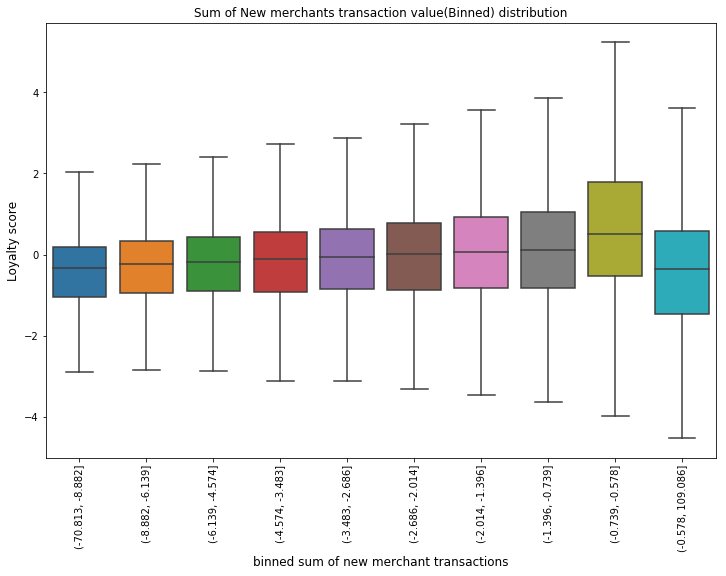

In [99]:
bins = np.nanpercentile(train_df['sum_merch_trans'],range(0,101,10))
train_df['binned_sum_merch_trans'] = pd.cut(train_df['sum_merch_trans'],bins)

plt.figure(figsize=(12,8))
sns.boxplot(x='binned_sum_merch_trans',y=target_col, data=train_df,showfliers=False)
plt.xticks(rotation='vertical')
plt.xlabel('binned sum of new merchant transactions',fontsize=12)
plt.ylabel('Loyalty score',fontsize=12)
plt.title('Sum of New merchants transaction value(Binned) distribution')
plt.show()


In [ ]:
# 除了最后一个箱子, 似乎忠诚度得分随着新用户的交易量增加而增加
#  再来看看 mean_merch_trans

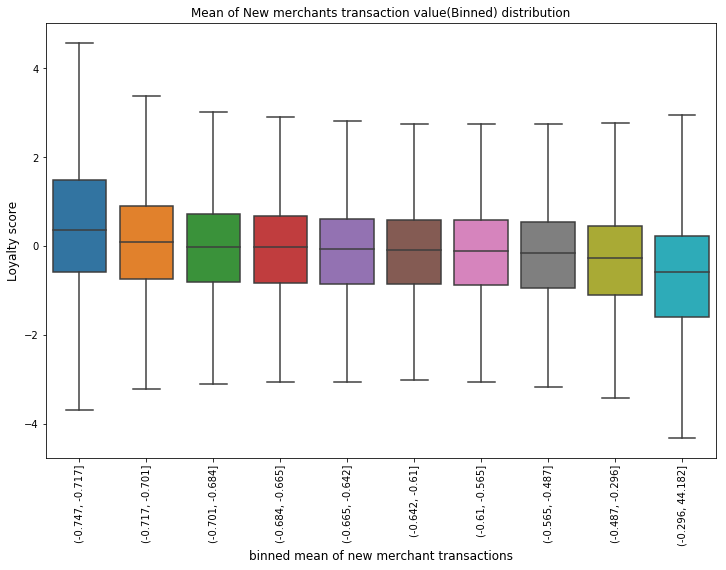

In [100]:
bins = np.nanpercentile(train_df['mean_merch_trans'],range(0,101,10))
train_df['binned_mean_merch_trans'] = pd.cut(train_df['mean_merch_trans'],bins)

plt.figure(figsize=(12,8))
sns.boxplot(x='binned_mean_merch_trans',y=target_col, data=train_df,showfliers=False)
plt.xticks(rotation='vertical')
plt.xlabel('binned mean of new merchant transactions',fontsize=12)
plt.ylabel('Loyalty score',fontsize=12)
plt.title('Mean of New merchants transaction value(Binned) distribution')
plt.show()

In [101]:
# 让我们用现有的 特征创建一个 基线模型


In [102]:
train_df['year'] = train_df['first_active_month'].dt.year
train_df['month'] = train_df['first_active_month'].dt.month
test_df['year'] = test_df['first_active_month'].dt.year
test_df['month'] = test_df['first_active_month'].dt.month

In [103]:
train_df.head(2)

,first_active_month,card_id,feature_1,feature_2,feature_3,target,num_hist_transactions,binned_num_his_transactions,sum_hist_trans,mean_hist_trans,...,binned_num_merch_transactions,sum_merch_trans,mean_merch_trans,std_merch_trans,min_merch_trans,max_merch_trans,binned_sum_merch_trans,binned_mean_merch_trans,year,month
0,2017-06-01,C_ID_92a2005557,5,2,1,-0.820283,260,"(200, 500]",-165.968739,-0.638341,...,"(20, 30]",-13.244202,-0.575835,0.135812,-0.724368,-0.296112,"(-70.813, -8.882]","(-0.61, -0.565]",2017,6
1,2017-01-01,C_ID_3d0044924f,4,1,0,0.392913,350,"(200, 500]",-210.006336,-0.600018,...,"(0, 10]",-4.355735,-0.725956,0.014326,-0.739410,-0.701858,"(-4.574, -3.483]","(-0.747, -0.717]",2017,1


In [107]:
cols_to_use = ['feature_1','feature_2','feature_3','year','month',
              'num_hist_transactions','sum_hist_trans','mean_hist_trans',
              'set_hist_trans','min_hist_trans','max_hist_trans',
              'num_merch_transactions','sum_merch_trans','mean_merch_trans',
              'std_merch_trans','min_merch_trans','max_merch_trans']


In [105]:
def run_lgb(train_X,train_y,val_X,val_y,test_X):
    params = {
        'objective' : 'regression',
        'metric' : 'rmse',
        'num_leaves' : 30,
        'min_child_weight' : 50,
        'learning_rate' : 0.05,
        'bagging_fraction' : 0.7,
        'feature_fraction' : 0.7,
        'bagging_frequency' : 5,
        'bagging_seed' : 2018,
        'verbosity' : -1
    }
    
    lgtrain = lgb.Dataset(train_X, label=train_y)
    lgval = lgb.Dataset(val_X, label=val_y)
    evals_result = {}
    model = lgb.train(params, lgtrain, 1000, valid_sets=[lgval],
                     early_stopping_rounds=100, verbose_eval=100,
                     evals_result=evals_result)
    pre_test_y = model.predict(test_X, num_iteration=model.best_iteration)
    return pre_test_y, model, evals_result
 

In [108]:
train_X = train_df[cols_to_use]
test_X = test_df[cols_to_use]
train_y = train_df[target_col].values

pre_test = 0
kf = model_selection.KFold(n_splits=5, random_state=2018,shuffle=True)

for dev_index, val_index in kf.split(train_df):
    dev_X, val_X = train_X.loc[dev_index,:], train_X.loc[val_index,:]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    
    pred_test_tmp, model, evals_result = run_lgb(dev_X,dev_y,val_X,val_y,test_X)
    pre_test += pred_test_tmp
    pre_test /= 5


Training until validation scores don't improve for 100 rounds.
[100]	valid_0's rmse: 3.81049
[200]	valid_0's rmse: 3.80984
Early stopping, best iteration is:
[163]	valid_0's rmse: 3.80946
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's rmse: 3.75935
[200]	valid_0's rmse: 3.75958
Early stopping, best iteration is:
[151]	valid_0's rmse: 3.75848
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's rmse: 3.80311
[200]	valid_0's rmse: 3.80228
[300]	valid_0's rmse: 3.80269
Early stopping, best iteration is:
[210]	valid_0's rmse: 3.80206
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's rmse: 3.7929
[200]	valid_0's rmse: 3.79349
Early stopping, best iteration is:
[145]	valid_0's rmse: 3.79269
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's rmse: 3.8547
[200]	valid_0's rmse: 3.85516
Early stopping, best iteration is:
[127]	valid_0's rmse: 3.85456


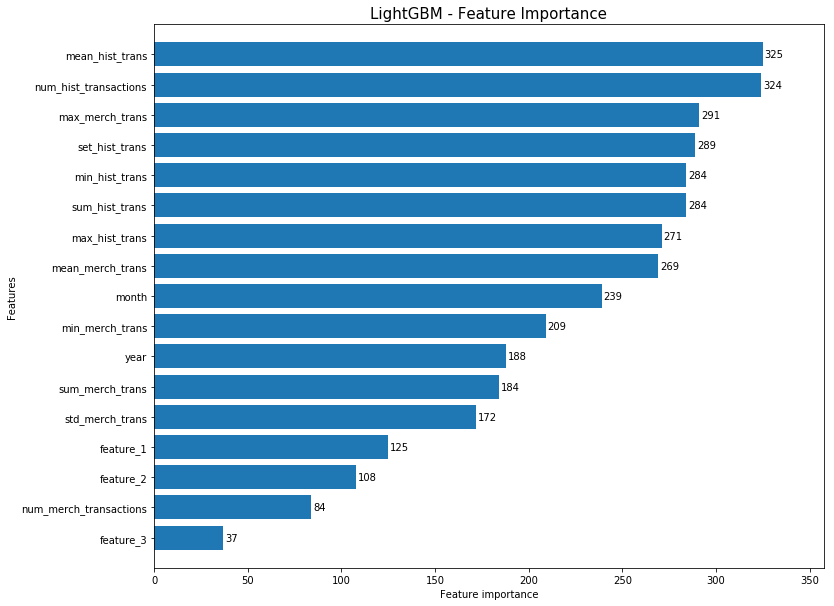

In [109]:
# 特征重要性
fig, ax = plt.subplots(figsize=(12,10))
lgb.plot_importance(model, max_num_features=50, height=0.8,ax=ax)
ax.grid(False)
plt.title('LightGBM - Feature Importance', fontsize=15)
plt.show()

In [110]:
sub_df = pd.DataFrame({'card_id':test_df['card_id'].values})
sub_df['target'] = pre_test
sub_df.to_csv('baseline_lgb.csv', index=False)